In [2]:
import numpy as np
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt
from collections import Counter
from heuristic import *
from HartRL import *
from evaluate import *

Initialize enviroment

In [4]:
# Parameters for the Multi-RAT Network
area_width = 150
n_aps = 9
n_users = 10
n_steps = 30
rat_env = Multi_RAT_Network(area_width, n_users, n_aps, n_steps, plot=False)
# Simulation parameters
n_episodes = 100


### Evaluate DQN

In [ ]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes)
print_stats(rewards, actions, n_users)

C:\Users\alvar\AppData\Local\Temp\ipykernel_28216\3852798495.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load("Action_Net.pt"))


TEST RESULTS with 10 users in 150 episodes (30000 stations chosen)
-----------------------------------------
9 APs chosen 25843 times (86.14%) | 4 LTEs chosen 4157 times (13.86%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.429 --> 257.291 Mb/s
Average reward in APs: 0.430 --> 257.846 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 2422, 3: 778, 2: 659, 1: 298})
APs chosen : Counter({8: 3819, 4: 3110, 7: 3018, 9: 2943, 5: 2839, 12: 2800, 10: 2521, 11: 2469, 6: 2324})


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
9 APs chosen 37358 times (83.02%) | 4 LTEs chosen 7642 times (16.98%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.408 --> 244.890 Mb/s
Average reward in APs: 0.415 --> 249.239 Mb/

Let's try tunning the hyperparameters to make it better, first gamma from 0.99 to 0.97 to 0.95

With 0.97 I would say it has improved:

TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
9 APs chosen 39479 times (87.73%) | 4 LTEs chosen 5521 times (12.27%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.424 --> 254.645 Mb/s
Average reward in APs: 0.432 --> 259.291 Mb/s

Let's go with 0.95

### Evaluate Heuristic algorithm

In [9]:
# Simuation parameters
h_value = 1
p_switch = 0.8
m = 0
h_rewards, h_actions = run_heuristic(rat_env, n_episodes, h_value, p_switch, m)
print_stats(h_rewards, h_actions, n_users)


Simulaton progess:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\alvar\Documents\TELECO\cuarto\2 º Cuatri\Thesis\Nash_DQN_RAT\heuristic.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards_buffer.append(torch.tensor(lr))
Simulaton progess: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


TEST RESULTS with 10 users in 150 episodes (30000 stations chosen)
-----------------------------------------
9 APs chosen 24003 times (80.01%) | 4 LTEs chosen 5997 times (19.99%)
User disconnected 173 times (0.57667 %)
Average reward in LTEs: 0.431 --> 258.456 Mb/s
Average reward in APs: 0.431 --> 258.624 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 1714, 1: 1561, 2: 1439, 3: 1283})
APs chosen : Counter({5: 3205, 9: 3124, 8: 3042, 11: 2790, 7: 2605, 10: 2581, 4: 2443, 12: 2222, 6: 1991})


### HartRL algorithm

Training

In [5]:
p_vectors = run_Hart_RL(rat_env, n_steps, sim_steps=300)

Simulation Progress: 100%|██████████| 300/300 [00:06<00:00, 49.45it/s]


Evaluation

In [53]:
hart_rewards,hart_actions = evaluate_hart_rl(p_vectors, rat_env, n_episodes)
print_stats(hart_rewards, hart_actions, n_users)


TEST RESULTS with 10 users in 150 episodes (30000 stations chosen)
-----------------------------------------
9 APs chosen 8624 times (28.75%) | 4 LTEs chosen 21376 times (71.25%)
User disconnected 9878 times (32.92667 %)
Average reward in LTEs: 0.049 --> 29.268 Mb/s
Average reward in APs: 0.048 --> 28.728 Mb/s
-----------------------------------------
LTEs chosen : Counter({2: 5468, 0: 5452, 3: 5305, 1: 5151})
APs chosen : Counter({8: 2360, 7: 1210, 9: 1145, 11: 1023, 4: 949, 10: 923, 5: 522, 6: 301, 12: 191})


### Plot results for DQN

Plot average_throughput per user and fairness

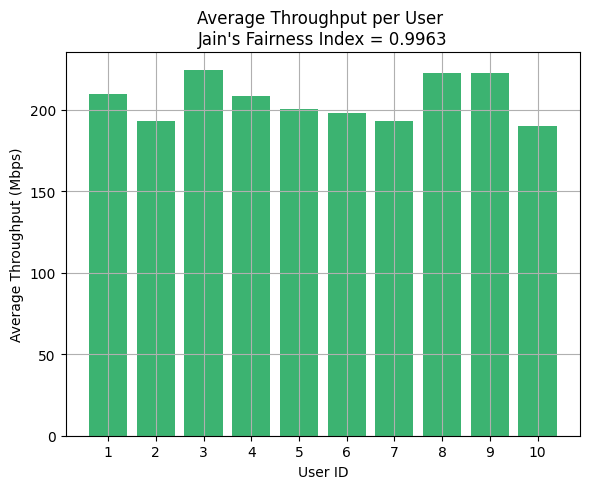

In [24]:
throughput_buffer = [
    [reward * rat_env.max_thr for reward in rewards]
    for rewards in rewards
]

# Step 3: Compute average throughput per user
n_users = len(throughput_buffer[0])
avg_throughput_per_user = [
    np.mean([throughput_buffer[episode][user] for episode in range(len(throughput_buffer))])
    for user in range(n_users)
]

# Step 4: Compute Jain's fairness index
numerator = (sum(avg_throughput_per_user)) ** 2
denominator = n_users * sum(x ** 2 for x in avg_throughput_per_user)
jain_index = numerator / denominator if denominator != 0 else 0

# Step 5: Plot average throughput per user
plt.figure(figsize=(6, 5))
plt.bar(range(n_users), avg_throughput_per_user, color='mediumseagreen')
plt.xlabel('User ID')
plt.xticks(ticks=range(n_users), labels=[f'{i+1}' for i in range(n_users)])
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per User \nJain\'s Fairness Index = {jain_index:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Just to check the variabliilty of the actoins and if they correspond to the rewards
#plot_actions(actions)
#plot_reward(rewards)
#plot_episode_reward(rewards, n_steps)


### Compare different algorithms results

Average Throughput and Fairness

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg_metrics(reward_data, n_steps, k, max_thr):
    avg_throughput = []
    avg_fairness = []
    throughput_accum = []
    fairness_accum = []

    for i, timestep_rewards in enumerate(reward_data):
        throughput = np.array(timestep_rewards) * max_thr
        throughput_accum.extend(throughput)
        numerator = (np.sum(throughput)) ** 2
        denominator = len(throughput) * np.sum(throughput ** 2)
        fairness = numerator / denominator if denominator != 0 else 0
        fairness_accum.append(fairness)
        if (i + 1) % (n_steps * k) == 0:
            avg_throughput.append(np.mean(throughput_accum))
            avg_fairness.append(np.mean(fairness_accum))
            throughput_accum = []
            fairness_accum = []
    
    return avg_throughput, avg_fairness

# Moving average window: every k episodes
k = 5

# Compute average metrics
episode_avg_throughput, episode_avg_fairness = compute_avg_metrics(rewards, n_steps, k, rat_env.max_thr)
episode_avg_throughput_h, episode_avg_fairness_h = compute_avg_metrics(h_rewards, n_steps, k, rat_env.max_thr)
episode_avg_throughput_hart, episode_avg_fairness_hart = compute_avg_metrics(hart_rewards, n_steps, k, rat_env.max_thr)

# X-axis values
x_vals = [(i + 1) * k for i in range(len(episode_avg_throughput))]

# --- Throughput Plot ---
plt.figure(figsize=(10, 5))
plt.plot(x_vals, episode_avg_throughput, color='tab:green', marker='o', label='DQN')
plt.plot(x_vals, episode_avg_throughput_h, color='tab:blue', marker='x', label='Heuristic')
plt.plot(x_vals, episode_avg_throughput_hart, color='tab:red', marker='^', label='HartRL')
plt.xlabel('Episodes')
plt.xticks(np.arange(0, max(x_vals)+1, 10))
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per {k} Episodes')
plt.grid(True)
plt.legend()
plt.show()

# --- Fairness Plot ---
plt.figure(figsize=(10, 5))
plt.plot(x_vals, episode_avg_fairness, color='tab:green', marker='o', label="DQN")
plt.plot(x_vals, episode_avg_fairness_h, color='tab:blue', marker='x', label="Heuristic")
plt.plot(x_vals, episode_avg_fairness_hart, color='tab:red', marker='^', label="HartRL")
plt.xlabel('Episodes')
plt.xticks(np.arange(0, max(x_vals)+1, 10))
plt.ylabel("Jain's Index")
plt.title(f"Average Fairness per {k} Episodes")
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'rewards' is not defined

Congestion analysis: % of users connected to top 4 busy stations

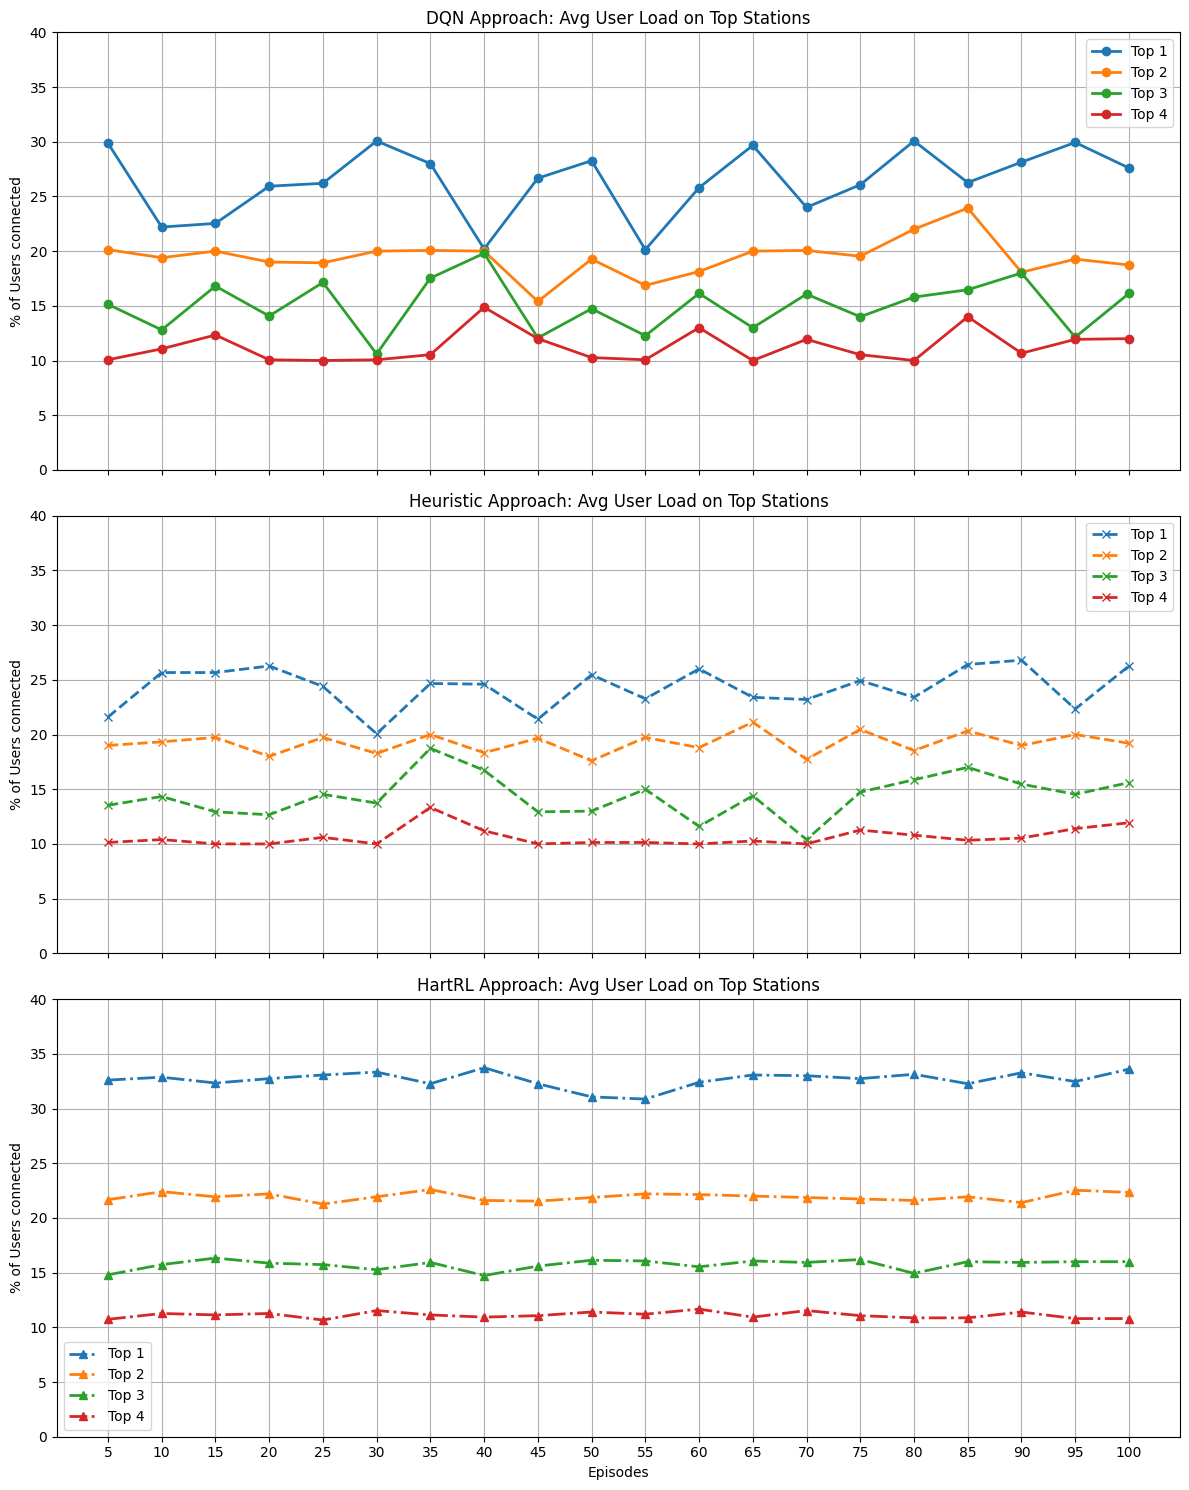

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_station_load(actions, h_actions, hart_actions, n_steps, max_episodes=None, k=1, top_k=4):
    n_users = rat_env.n_users
    n_timesteps = len(actions)
    total_episodes = n_timesteps // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)

    grouped_episode_count = n_episodes // k

    def compute_top_k_percentages(action_seq):
        top_k_percentages = [[] for _ in range(top_k)]
        for group in range(grouped_episode_count):
            group_top_k = [[] for _ in range(top_k)]
            for ep in range(group * k, (group + 1) * k):
                ep_start = ep * n_steps
                ep_end = (ep + 1) * n_steps
                for t in range(ep_start, ep_end):
                    station_counts = Counter(a.item() for a in action_seq[t])
                    top_k_counts = station_counts.most_common(top_k)
                    for i in range(top_k):
                        if i < len(top_k_counts):
                            percent = (top_k_counts[i][1] / n_users) * 100
                        else:
                            percent = 0.0
                        group_top_k[i].append(percent)
            for i in range(top_k):
                top_k_percentages[i].append(np.mean(group_top_k[i]))
        return top_k_percentages

    # Compute top-k usage
    dqn_top_k = compute_top_k_percentages(actions)
    heuristic_top_k = compute_top_k_percentages(h_actions)
    hart_top_k = compute_top_k_percentages(hart_actions)

    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]
    colors = plt.cm.tab10.colors

    # Prepare 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

    # ---Plot DQN---
    for i in range(top_k):
        axes[0].plot(x_vals, dqn_top_k[i], marker='o', linewidth=2, color=colors[i % len(colors)], label=f'Top {i+1}')
    axes[0].set_title('DQN Approach: Avg User Load on Top Stations')
    axes[0].set_ylabel('% of Users connected')
    axes[0].set_ylim(0, 40)
    axes[0].grid(True)
    axes[0].legend()

    # ---Plot Heuristic---
    for i in range(top_k):
        axes[1].plot(x_vals, heuristic_top_k[i], marker='x', linestyle='--', linewidth=2, color=colors[i % len(colors)], label=f'Top {i+1}')
    axes[1].set_title('Heuristic Approach: Avg User Load on Top Stations')
    axes[1].set_ylabel('% of Users connected')
    axes[1].set_ylim(0, 40)
    axes[1].grid(True)
    axes[1].legend()

    # ---Plot HartRL---
    for i in range(top_k):
        axes[2].plot(x_vals, hart_top_k[i], marker='^', linestyle='-.', linewidth=2, color=colors[i % len(colors)], label=f'Top {i+1}')
    axes[2].set_title('HartRL Approach: Avg User Load on Top Stations')
    axes[2].set_xlabel('Episodes')
    axes[2].set_ylabel('% of Users connected')
    axes[2].set_ylim(0, 40)
    axes[2].grid(True)
    axes[2].legend()

    plt.xticks(x_vals)
    plt.tight_layout()
    plt.show()

#Example usage
plot_station_load(actions, h_actions, hart_actions, n_steps, max_episodes=100, k=5, top_k=4)


Proportion of users connected to LTE vs Wifi over time

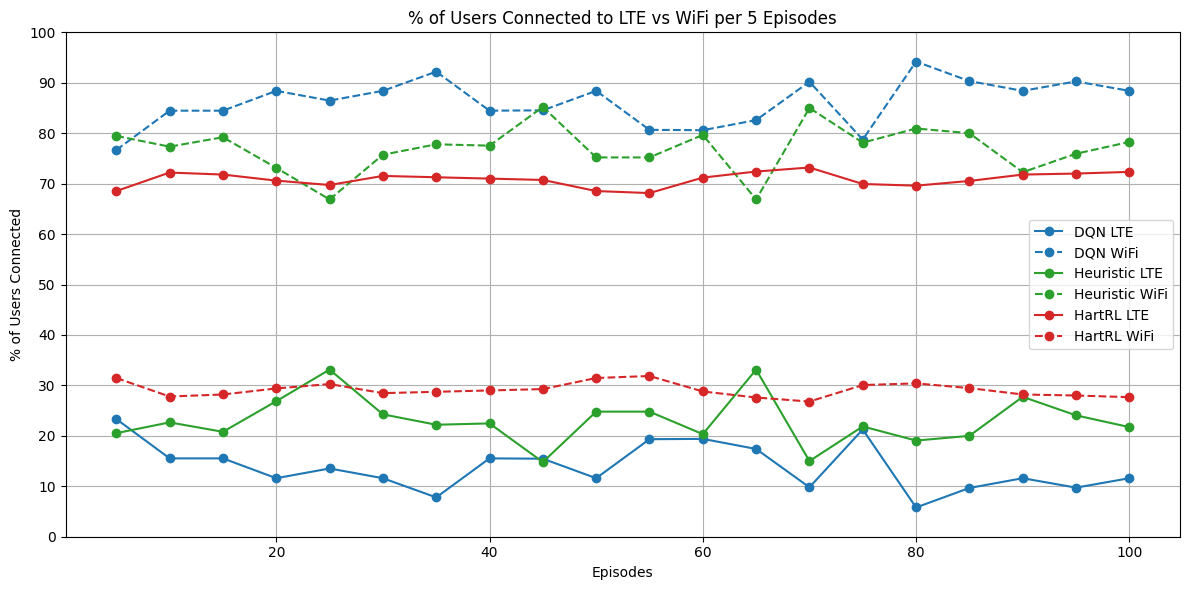

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_rat_split(actions, h_actions, hart_actions, n_steps, max_episodes=None, k=1):
    n_users = rat_env.n_users
    lte_station_ids = list(range(rat_env.n_ltesn))
    ap_station_ids = list(range(rat_env.n_ltesn, rat_env.n_stations))

    n_timesteps = len(actions)
    total_episodes = n_timesteps // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)
    grouped_episode_count = n_episodes // k

    def compute_rat_percentages(action_seq):
        lte_percent_per_group = []
        ap_percent_per_group = []
        for group in range(grouped_episode_count):
            lte_accum = []
            ap_accum = []
            for ep in range(group * k, (group + 1) * k):
                ep_start = ep * n_steps
                ep_end = (ep + 1) * n_steps
                for t in range(ep_start, ep_end):
                    station_counts = Counter(a.item() for a in action_seq[t])
                    lte_connected = sum(station_counts.get(st_id, 0) for st_id in lte_station_ids)
                    ap_connected = sum(station_counts.get(st_id, 0) for st_id in ap_station_ids)
                    lte_percent = (lte_connected / n_users) * 100
                    ap_percent = (ap_connected / n_users) * 100
                    lte_accum.append(lte_percent)
                    ap_accum.append(ap_percent)
            lte_percent_per_group.append(np.mean(lte_accum))
            ap_percent_per_group.append(np.mean(ap_accum))
        return lte_percent_per_group, ap_percent_per_group

    # Compute RAT splits
    dqn_lte, dqn_ap = compute_rat_percentages(actions)
    h_lte, h_ap = compute_rat_percentages(h_actions)
    hart_lte, hart_ap = compute_rat_percentages(hart_actions)

    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]

    plt.figure(figsize=(12, 6))

    # Define colors for algorithms
    dqn_color = 'tab:green'
    heuristic_color = 'tab:blue'
    hart_color = 'tab:red'

    # DQN
    plt.plot(x_vals, dqn_lte, label='DQN LTE', color=dqn_color, linestyle='-', marker='o')
    plt.plot(x_vals, dqn_ap, label='DQN WiFi', color=dqn_color, linestyle='--', marker='o')

    # Heuristic
    plt.plot(x_vals, h_lte, label='Heuristic LTE', color=heuristic_color, linestyle='-', marker='o')
    plt.plot(x_vals, h_ap, label='Heuristic WiFi', color=heuristic_color, linestyle='--', marker='o')

    # HartRL
    plt.plot(x_vals, hart_lte, label='HartRL LTE', color=hart_color, linestyle='-', marker='o')
    plt.plot(x_vals, hart_ap, label='HartRL WiFi', color=hart_color, linestyle='--', marker='o')

    plt.xlabel('Episodes')
    plt.ylabel('% of Users Connected')
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f'% of Users Connected to LTE vs WiFi per {k} Episodes')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_rat_split(actions, h_actions, hart_actions, n_steps, max_episodes=100, k=5)



+------------+-----------------------------+
|  Method    | Avg % of Users Disconnected |
+------------+-----------------------------+
| DQN        |                        0.00% |
| Heuristic  |                        0.77% |
| HartRL     |                       32.93% |
+------------+-----------------------------+



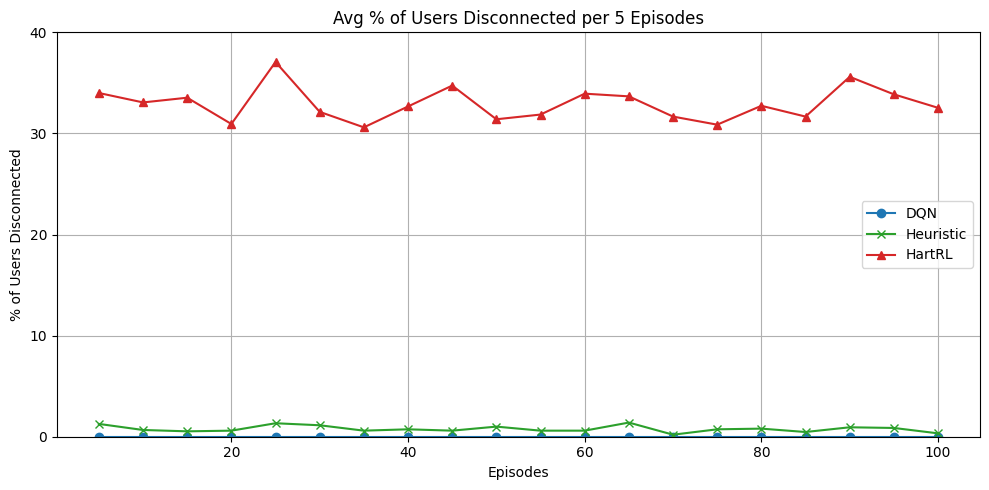

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_disconnected_percentage(reward_data, n_steps, k):
    n_users = rat_env.n_users
    disconnected_percentages = []

    grouped_episode_count = len(reward_data) // (n_steps * k)

    for group in range(grouped_episode_count):
        group_disconnected = []
        for ep in range(group * k, (group + 1) * k):
            start = ep * n_steps
            end = (ep + 1) * n_steps
            for t in range(start, end):
                rewards_t = reward_data[t]
                disconnected = sum(1 for r in rewards_t if r < 0)
                disconnected_percent = (disconnected / n_users) * 100
                group_disconnected.append(disconnected_percent)
        disconnected_percentages.append(np.mean(group_disconnected))

    return disconnected_percentages

def compute_total_disconnected_percentage(reward_data):
    n_users = rat_env.n_users
    total_disconnected = 0
    count = 0

    for rewards_t in reward_data:
        disconnected = sum(1 for r in rewards_t if r < 0)
        total_disconnected += (disconnected / n_users) * 100
        count += 1

    return total_disconnected / count

# Compute data
k = 5
dqn_disconnected = compute_disconnected_percentage(rewards, n_steps, k)
heuristic_disconnected = compute_disconnected_percentage(h_rewards, n_steps, k)
hart_disconnected = compute_disconnected_percentage(hart_rewards, n_steps, k)

# Compute total averages
total_dqn = compute_total_disconnected_percentage(rewards)
total_heuristic = compute_total_disconnected_percentage(h_rewards)
total_hart = compute_total_disconnected_percentage(hart_rewards)

# Print text table
print("\n+------------+-----------------------------+")
print("|  Method    | Avg % of Users Disconnected |")
print("+------------+-----------------------------+")
print(f"| DQN        | {total_dqn:>27.2f}% |")
print(f"| Heuristic  | {total_heuristic:>27.2f}% |")
print(f"| HartRL     | {total_hart:>27.2f}% |")
print("+------------+-----------------------------+\n")

# X-axis
x_vals = [(i + 1) * k for i in range(len(dqn_disconnected))]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_vals, dqn_disconnected, color='tab:green', marker='o', label='DQN')
plt.plot(x_vals, heuristic_disconnected, color='tab:blue', marker='x', label='Heuristic')
plt.plot(x_vals, hart_disconnected, color='tab:red', marker='^', label='HartRL')

plt.xlabel('Episodes')
plt.ylabel('% of Users Disconnected')
plt.title(f'Avg % of Users Disconnected per {k} Episodes')
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0.0, 40)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Number of switches

Hart Switch % sample: [86.13333333333334, 83.4, 85.4, 83.53333333333333, 86.06666666666666, 84.73333333333333, 85.53333333333333, 85.13333333333334, 84.2, 86.06666666666666]


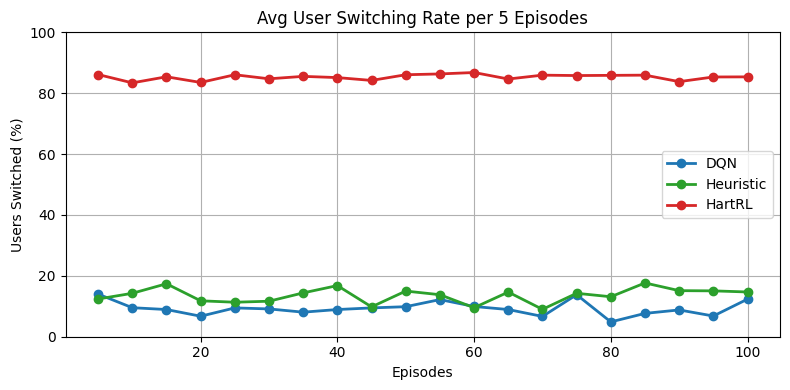

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_switching(actions, h_actions, hart_actions, n_steps, max_episodes=None, k=1):
    def compute_switch_percentages(action_seq):
        n_users = rat_env.n_users
        user_connections = [action.tolist() for action in action_seq]
        switch_percentages = []
        for t in range(1, len(user_connections)):
            prev = user_connections[t - 1]
            curr = user_connections[t]
            switches = sum(1 for i in range(n_users) if prev[i] != curr[i])
            switch_percentages.append((switches / n_users) * 100)
        return switch_percentages


    dqn_switch = compute_switch_percentages(actions)
    heuristic_switch = compute_switch_percentages(h_actions)
    hart_switch = compute_switch_percentages(hart_actions)

    total_episodes = len(actions) // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)
    grouped_episode_count = n_episodes // k

    def aggregate_switch(switch_list):
        result = []
        for group in range(grouped_episode_count):
            group_switch = []
            for ep in range(group * k, (group + 1) * k):
                start = ep * n_steps
                end = (ep + 1) * n_steps
                group_switch.extend(switch_list[start:end])
            result.append(np.mean(group_switch))
        return result

    dqn_grouped = aggregate_switch(dqn_switch)
    heuristic_grouped = aggregate_switch(heuristic_switch)
    hart_grouped = aggregate_switch(hart_switch)
    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]

    plt.figure(figsize=(8, 4))
    plt.plot(x_vals, dqn_grouped, color='tab:green', linewidth=2, marker='o', label='DQN')
    plt.plot(x_vals, heuristic_grouped, color='tab:blue', linewidth=2, marker='o', label='Heuristic')
    plt.plot(x_vals, hart_grouped, color='tab:red', linewidth=2, marker='o', label='HartRL')

    plt.xlabel('Episodes')
    plt.ylabel('Users Switched (%)')
    plt.title(f'Avg User Switching Rate per {k} Episodes')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_switching(actions, h_actions, hart_actions, n_steps, max_episodes=100, k=5)


Number of stations unused

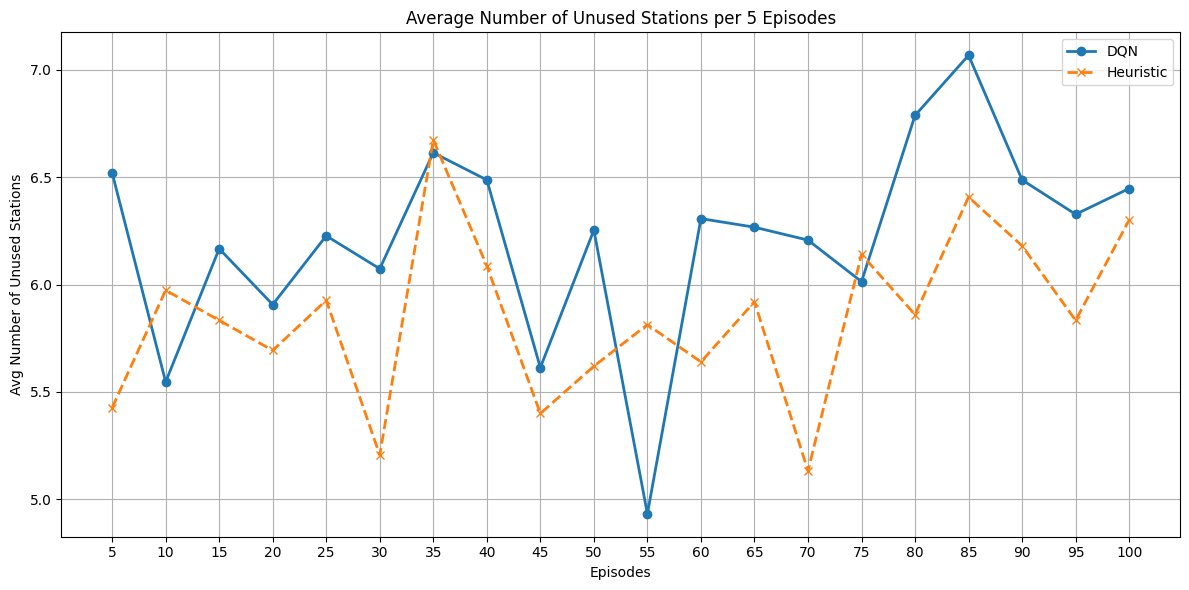

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_unused_stations(actions, h_actions, hart_actions, n_steps, max_episodes=None, k=1):
    n_stations = rat_env.n_stations
    n_timesteps = len(actions)
    total_episodes = n_timesteps // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)
    grouped_episode_count = n_episodes // k

    def compute_unused_station_counts(action_seq):
        unused_counts_per_group = []
        for group in range(grouped_episode_count):
            unused_counts = []
            for ep in range(group * k, (group + 1) * k):
                ep_start = ep * n_steps
                ep_end = (ep + 1) * n_steps
                for t in range(ep_start, ep_end):
                    station_counts = Counter(a.item() for a in action_seq[t])
                    unused = sum(1 for st_id in range(n_stations) if station_counts.get(st_id, 0) == 0)
                    unused_counts.append(unused)
            unused_counts_per_group.append(np.mean(unused_counts))
        return unused_counts_per_group

    dqn_unused = compute_unused_station_counts(actions)
    heuristic_unused = compute_unused_station_counts(h_actions)
    hart_unused = compute_unused_station_counts(hart_actions)


    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]

    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, dqn_unused, marker='o', linewidth=2, color='tab:green', label='DQN')
    plt.plot(x_vals, heuristic_unused, marker='o', linestyle='--', linewidth=2, color='tab:blue', label='Heuristic')
    plt.plot(x_vals, hart_unused, marker='o', linestyle='--', linewidth=2, color='tab:red', label='Heuristic')

    plt.xlabel('Episodes')
    plt.ylabel('Avg Number of Unused Stations')
    plt.title(f'Average Number of Unused Stations per {k} Episodes')
    plt.xticks(x_vals)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_unused_stations(actions, h_actions, n_steps, max_episodes=100, k=5)


Nash Equilibrium

In [3]:
from nash_equilibrium import *
# Parameters for the Multi-RAT Network
area_width = 150
n_aps = 9
n_users = 10
n_steps = 30
rat_env = Multi_RAT_Network(area_width, n_users, n_aps, n_steps, plot=False)
# Simulation parameters
n_episodes = 100
k = 5
# DQN parameters
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))
# Heuristic parameters
h_value = 1
p_switch = 0.8
m = 0

C:\Users\alvar\AppData\Local\Temp\ipykernel_23028\2024433029.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load("Action_Net.pt"))

In [ ]:
dqn_ne = dqn_nash_eq(rat_env, action_network, n_episodes, k)
heuristic_ne = heuristic_nash_eq(rat_env, n_episodes, k, h_value, p_switch, m)
hartrl_ne = hartrl_nash_eq(rat_env, p_vectors, n_episodes, k)

Evaluating HartRL Episodes: 100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


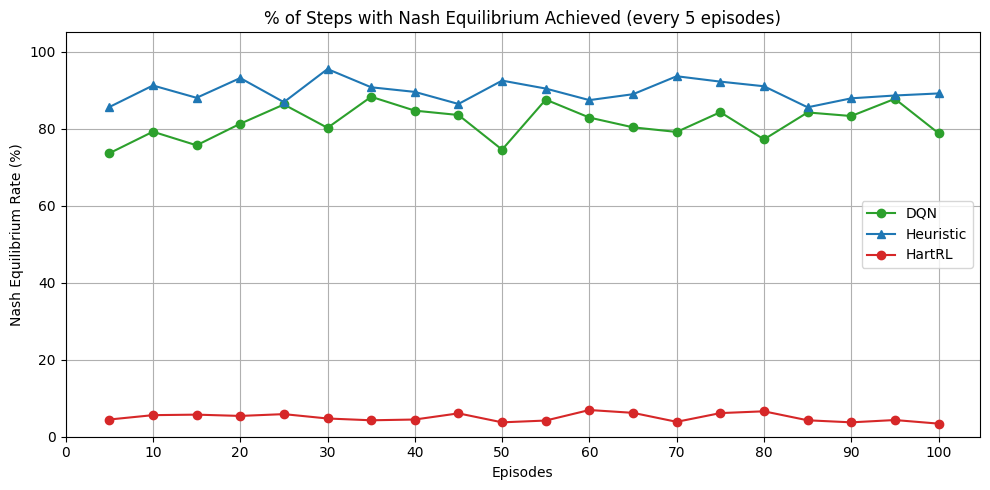

In [12]:

# X-axis values (shared across all methods)
x_vals = [(i + 1) * k for i in range(len(dqn_ne))]

# Plotting all three NE rate curves
plt.figure(figsize=(10, 5))

plt.plot(x_vals, dqn_ne, color='tab:green', marker='o', label='DQN')
plt.plot(x_vals, heuristic_ne, color='tab:blue', marker='^', label='Heuristic')
plt.plot(x_vals, hartrl_ne, color='tab:red', marker='o', label='HartRL')

plt.xlabel('Episodes')
plt.ylabel('Nash Equilibrium Rate (%)')
plt.title(f'% of Steps with Nash Equilibrium Achieved (every {k} episodes)')
plt.grid(True)
plt.xticks(range(0, max(x_vals) + 1, max(k, 10)))
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()
plt.show()